In [1]:
import ast
import configparser
import datetime
import logging
import os
import sys
sys.path.append('/0.db/01.codeshare/')
from Zj_functions.handle_metadata import *
from Zj_functions.clean_adata import *
from Zj_functions.dir_create import *
from Zj_functions.formatted_title import *
from Zj_functions.remove_noise_genes import *
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad

import omicverse as ov
import cellrank as cr

import scvelo as scv
import infercnvpy

# 设置显示选项
pd.set_option('display.max_columns', None)  # 显示所有列
# pd.set_option('display.max_rows', None)     # 显示所有行
# pd.set_option('display.width', None)        # 自动调整显示宽度
# pd.set_option('display.precision', 2)       # 设置浮点数显示精度为2
ov.ov_plot_set()

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

color_neu = ["#A65628", "#8DD3C7", "#BEBADA", "#cf929e", "#FB8072", "#80B1D3","#FDB462", "#B3DE69", "#FCCDE5", 
"#BC80BD", "#CCEBC5", "#e5a84b", "#d23918", "#E5C494", "#8DA0CB", "#E78AC3", "#bec2b3" ,
"#FFF2AE" ,"#b49273", "#d8de8a", "#cb5c83", "#9ECAE1", "#ecb0c1" ,"#4DAF4A","#a9be7b" ]
color=['#1b9e77', '#ad494a', '#d62728', '#bcbddc', '#d6616b', '#b5cf6b', '#bd9e39', '#e7cb94', '#8c6d31',
 '#e7ba52', '#b15928', '#7b4173', '#6baed6', '#bdbdbd', '#6a3d9a', '#dadaeb', '#843c39', '#c7e9c0',
 '#5254a3', '#9c9ede', '#fdd0a2', '#de9ed6', '#31a354', '#9ECAE1', '#d23918', '#b49273', '#8c564b',
 '#a1d99b', '#d8de8a', '#E78AC3', '#74c476', '#ffff99', '#e7969c', '#7f7f7f', '#e6550d', '#9e9ac8',
 '#4DAF4A', '#3182bd', '#6b6ecf', '#b5cf6b', '#a55194', '#2ca02c', '#ecb0c1', '#636363', '#d9d9d9',
 '#80B1D3', '#9ecae1', '#e5a84b', '#17becf', '#cf929e', '#bcbd22', '#8DA0CB', '#a9be7b', '#c6dbef',
 '#e377c2', '#8ca252', '#BEBADA', '#e7ba52', '#FDB462', '#8DD3C7', '#FCCDE5', '#9467bd', '#fb8072',
 '#ce6dbd', '#cd9ede', '#E5C494', '#bcc2b3', '#ff7f0e', '#BC80BD', '#fd8d3c', '#FFF2AE', '#ccEBc5',
 '#9c9ede', '#fb8072', '#ad494a', '#8c6d31', '#d6616b', '#8DA0CB', '#e7969c', '#a55194', '#9c9ede',
 '#6a3d9a', '#ff7f00', '#b15928', '#ffff99', '#1b9e77', '#637939', '#8ca252', '#b5cf6b', '#cedb9c']


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.7, Tutorials: https://omicverse.readthedocs.io/
Dependency error: The 'scrublet>=0.2' distribution was not found and is required by the application
scanpy==1.10.3 anndata==0.10.9 umap==0.5.6 numpy==1.23.5 scipy==1.11.4 pandas==1.5.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.5 louvain==0.8.0 pynndescent==0.5.13


In [ ]:
import h5py
f = h5py.File("BCC_GSE123813_aPD1/BCC_GSE123813_aPD1_expression.h5", 'r')

def visit(name, obj):
    print(name)
f.visititems(visit)

In [9]:
# 读取h5表达矩阵
adata = sc.read_10x_h5(
    "BCC_GSE123813_aPD1/BCC_GSE123813_aPD1_expression.h5",
    gex_only=False  ！
)
adata

reading BCC_GSE123813_aPD1/BCC_GSE123813_aPD1_expression.h5
 (0:00:00)


AnnData object with n_obs × n_vars = 52884 × 20638
    var: 'gene_ids', 'feature_types', 'genome'

In [12]:
# 读取 metadata
meta = pd.read_csv(
    "BCC_GSE123813_aPD1/BCC_GSE123813_aPD1_CellMetainfo_table.tsv",
    sep='\t',
    index_col=0
)
# 对齐
adata = adata[adata.obs_names.isin(meta.index)]
meta = meta.loc[adata.obs_names]
# 整合
adata.obs = meta

In [15]:
adata.obsm['X_umap'] = adata.obs[['UMAP_1', 'UMAP_2']].to_numpy()
adata

AnnData object with n_obs × n_vars = 52884 × 20638
    obs: 'UMAP_1', 'UMAP_2', 'Celltype (malignancy)', 'Celltype (major-lineage)', 'Celltype (minor-lineage)', 'Celltype (original)', 'Cluster', 'TimePoint', 'Sort', 'Celltype', 'Response', 'Patient', 'Source', 'Age', 'Gender', 'Stage', 'TNMstage', 'Treatment'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'X_umap'

... storing 'Celltype (malignancy)' as categorical
... storing 'Celltype (major-lineage)' as categorical
... storing 'Celltype (minor-lineage)' as categorical
... storing 'Celltype (original)' as categorical
... storing 'TimePoint' as categorical
... storing 'Sort' as categorical
... storing 'Celltype' as categorical
... storing 'Response' as categorical
... storing 'Patient' as categorical
... storing 'Source' as categorical
... storing 'Stage' as categorical
... storing 'Treatment' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


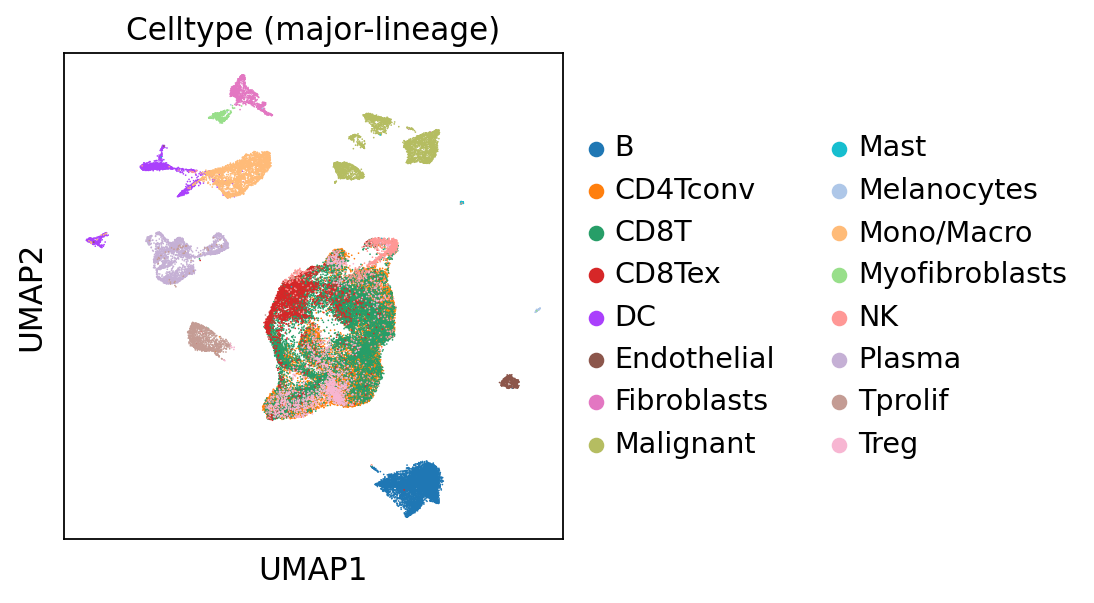

In [16]:
sc.pl.umap(adata, color='Celltype (major-lineage)')

In [ ]:
adata.write_h5ad("BCC_GSE123813_aPD1/01_ad_BCC_GSE123813_aPD1_raw.h5ad")